#### 1. Make a combined bed files across all samples and obtain read counts

In [8]:
library(parallel)

In [9]:
## only 10 European samples
ids = c(2:5, 8:10,12:14)

In [10]:
sampdir  = '/nfs/lab/projects/pbmc_snATAC/analysis_v2/cell_type_bam/'
outdir   = '/nfs/lab/projects/pbmc_snATAC/analysis_v2/rasqual_eur/'
bedir    = '/nfs/lab/projects/pbmc_snATAC/analysis_v2/peaks/'

In [11]:
saf = paste0(bedir, 'pbmc.sorted.merged.saf')

In [50]:
system(paste('python /home/pbenaglio/general_scripts/convert_bed_to_saf.py', 
              paste0(bedir, 'pbmc.sorted.merged.bare.bed'), saf))

In [5]:
featurecounts = function(c, res = "fine"){
outfolder     = paste(outdir, res, c, sep="/")
system(paste('mkdir -p' , outfolder))
count_matrix  = paste0(outfolder,"/" ,c, '.count_matrix')    
bam           = paste0(sampdir, "PBMC", ids,"/" ,res, '/pbmc', ids, "_", c, ".bam")
gi  <-  paste("featureCounts -p -T 10 -F SAF --donotsort -a" , saf, "-o",  count_matrix , 
                paste(bam,collapse=" "))
system(gi)
}



In [52]:
celltypes = as.character(read.table(paste0(bedir,"color_scheme.tsv"))[,2])

In [53]:
celltypes = celltypes[1:15]

In [54]:
celltypes

[1] "cMono"       "ncMono"      "iMono"       "cDC"         "mem_b"      
 [6] "naive_b"     "cyto_nk"     "adaptive_NK" "naive_cd8_t" "cyto_cd8_t" 
[11] "mem_cd8_t"   "naive_cd4_t" "act_cd4_t"   "tReg"        "mkc"

In [55]:
mclapply(celltypes,featurecounts, mc.cores = 32 )

[[1]]
[1] 0

[[2]]
[1] 0

[[3]]
[1] 0

[[4]]
[1] 0

[[5]]
[1] 0

[[6]]
[1] 0

[[7]]
[1] 0

[[8]]
[1] 0

[[9]]
[1] 0

[[10]]
[1] 0

[[11]]
[1] 0

[[12]]
[1] 0

[[13]]
[1] 0

[[14]]
[1] 0

[[15]]
[1] 0

In [56]:
celltypes = c('b', 'cd4_t', 'cd8_t', 'mono', 'nk' )

In [57]:
ids

[1]  2  3  4  5  8  9 10 12 13 14

In [58]:
mclapply(celltypes,function(x) featurecounts(x, res="broad"), mc.cores = 32 )

[[1]]
[1] 0

[[2]]
[1] 0

[[3]]
[1] 0

[[4]]
[1] 0

[[5]]
[1] 0

In [6]:
celltypes = 't'

In [7]:
mclapply(celltypes,function(x) featurecounts(x, res="broad"), mc.cores = 32 )

[[1]]
[1] 0

In [7]:
### pseudobulk matrix
res = "bulk"
c   =  'bulk'
outfolder     = paste(outdir, res, c, sep="/")
system(paste('mkdir -p' , outfolder))
count_matrix  = paste0(outfolder,"/" ,c, '.count_matrix')    
bam           = paste0("/nfs/lab/projects/pbmc_snATAC/analysis_v2/wasp_peaks/bulk/PBMC", ids, '/rmdup/PBMC', ids, '.keep.merged.rmdup.bam' )
gi  <-  paste("featureCounts -p -T 10 -F SAF --donotsort -a" , saf, "-o",  count_matrix , 
                paste(bam,collapse=" "))
system(gi)




#### 2. Filter the read count matrix and use rasqual tools to generate the input files

In [12]:
library("rasqualTools")
source("/nfs/lab/projects/pbmc_snATAC/scripts/rasqual_tools_functions.R")

In [10]:
#res="fine"
#celltypes = as.character(read.table(paste0(bedir,"color_scheme.tsv"))[,2])[1:15]
 #res="broad"
 #celltypes = c('b', 'cd4_t', 'cd8_t', 'mono', 'nk' )
 res="bulk"
 celltypes= "bulk"

In [13]:
res = "broad"
celltypes   =  't'


In [1]:
for (c in celltypes){
outfolder     = paste(outdir, res, c, sep="/")
cm = read.table(paste0(outfolder, "/" ,c, '.count_matrix') , header=T)
colnames(cm)[7:ncol(cm)] = paste0("PBMC", ids)

### filter for peaks having a minumum of 5 reads on avg per sample
cm = cm[rowMeans(cm[,7:ncol(cm)])>= 5, ]

fmat           = cm[,7:ncol(cm)]
rownames(fmat) = cm[,1]
filtbed        = paste0(outfolder, "/", c, ".filtered.bed")
write.table(fmat, paste0(outfolder, "/", c, ".filtered.count_matrix"), sep="\t", quote=F)
write.table(cm[,2:4],filtbed, sep="\t", quote=F, col.names=F, row.names=F)
cc     = cm[,2:4]
cc[,1] = substring(cc[,1],4)
write.table(cc, paste0(outfolder, "/", c, ".filtered.nochr.bed"), sep="\t", quote=F, col.names=F, row.names=F)

system(paste0("bedtools slop -i ",  filtbed,  " -b 10000 -g /nfs/lab/publicdata/human.hg19.genome.bedtools > ",
         filtbed, '.10kb'))

system(paste0("bedtools merge -i ", filtbed, '.10kb > ', filtbed, '.10kb.merged'))

fb     = read.table(paste0( filtbed, '.10kb.merged'))
fb[,1] = substring(fb[,1],4)
write.table(fb, paste0( filtbed, '.10kb.merged.nochr'), sep="\t", quote=F, col.names=F, row.names=F)

#### RAsqualTools

saveRasqualMatrices(list(counts = fmat), outfolder, file_suffix = c)

size_factors = rasqualCalculateSampleOffsets(fmat, gc_correct = FALSE)
saveRasqualMatrices(list(size_factors = size_factors),  outfolder, file_suffix = c)

y = paste0(outfolder, "/counts.",c, ".txt" )
k = paste0(outfolder, "/size_factors.",c, ".txt" )
x = paste0(outfolder, "/covariates.",c, ".txt" )

make_covariates (ytxt=y, ktxt=k, outfile=x)

txt2bin  (ytxt=y, ktxt=k, xtxt=x)
}

ERROR: Error in eval(expr, envir, enclos): object 'celltypes' not found


### Check the PCA

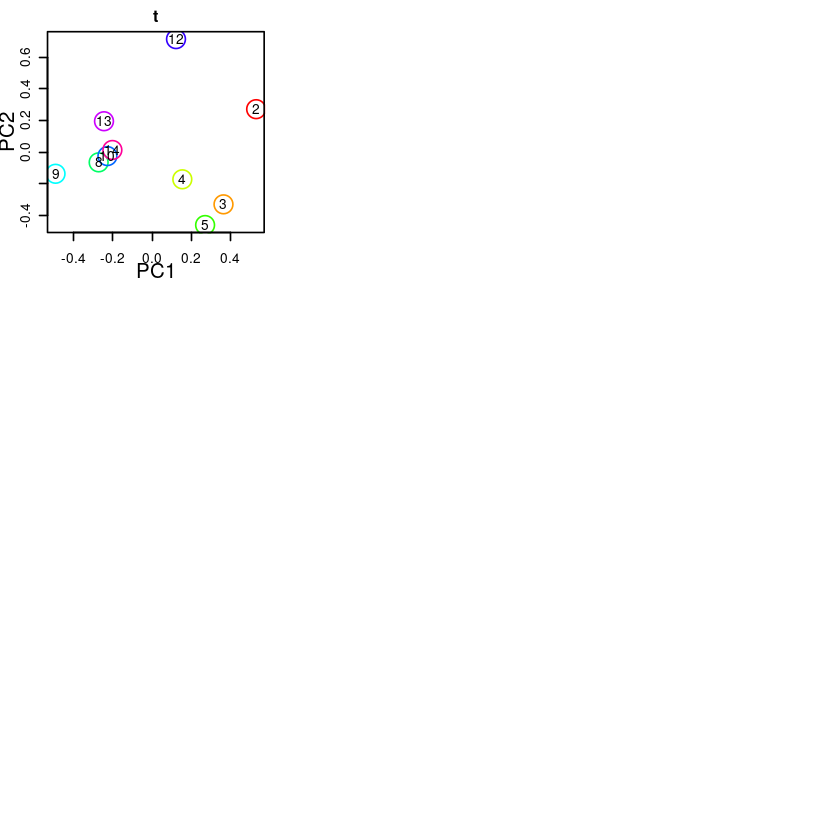

In [15]:
par(mfrow=c(3,3), mar =c(3,3,2,1))
for (c in celltypes){
outfolder     = paste(outdir, res, c, sep="/")
pca = read.table(paste0(outfolder, "/covariates.",c, ".txt" ))
   
plot(pca[,2:3], cex = 3, main = c, col = rainbow(length(ids))) ## col1 is size factor
mtext(side = 1:2, text=c("PC1","PC2"), line=2)
text(pca[,2:3], labels = ids)
#plot(pca[,3:4], cex = 3, main = c) ## col1 is size factor
#text(pca[,3:4], labels = ids)
#mtext(side = 1:2, text=c("PC2","PC3"), line=2)    
}

There are some outliers in a few cell types, but it will be corrected as covariates - https://github.com/natsuhiko/rasqual/issues/39

## Add 4 PCs from ancestry as covariates (1KG)

In [16]:
outdir

[1] "/nfs/lab/projects/pbmc_snATAC/analysis_v2/rasqual_eur/"

In [17]:
codir = '/nfs/lab/projects/pbmc_snATAC/analysis_v2/rasqual/covariates/'
for (c in celltypes){
outfolder     = paste(outdir, res, c, sep="/")
y = paste0(outfolder, "/counts.",c, ".txt" )
k = paste0(outfolder, "/size_factors.",c, ".txt" )
x = paste0(outfolder, "/covariates.",c, ".txt" )
    
make_covariates (ytxt=y, ktxt=k, outfile=x) ###recalculate original ones 
#newcov = cbind(read.table(x), read.table(paste0(codir, "4_gt_pcs")))
newcov = cbind(read.table(x),
               read.table(paste0(codir, "age"))[-c(1,6,13),],
               read.table(paste0(codir, "sex"))[-c(1,6,13),]*0.1, 
               read.table(paste0(codir, "4_gt_pcs"))[-c(1,6,13),])

write.table( newcov, x, col=F,row=F,sep="\t",quote=F)
txt2bin  (ytxt=y, ktxt=k, xtxt=x)
}

### version without sex and age

In [22]:
# res="fine"
# celltypes = as.character(read.table(paste0(bedir,"color_scheme.tsv"))[,2])[1:15]
#  res="broad"
#  celltypes = c('b', 'cd4_t', 'cd8_t', 'mono', 'nk' )
#  res="bulk"
# celltypes= "bulk"

In [18]:
res = "broad"
celltypes   =  't'


In [19]:
codir = '/nfs/lab/projects/pbmc_snATAC/analysis_v2/rasqual/covariates/'
for (c in celltypes){
outfolder     = paste(outdir, res, c, sep="/")
y = paste0(outfolder, "/counts.",c, ".txt" )
k = paste0(outfolder, "/size_factors.",c, ".txt" )
x = paste0(outfolder, "/covariates2.",c, ".txt" )
    
make_covariates (ytxt=y, ktxt=k, outfile=x) ###recalculate original ones 
#newcov = cbind(read.table(x), read.table(paste0(codir, "4_gt_pcs")))
newcov = cbind(read.table(x),
               #read.table(paste0(codir, "age"))[-c(1,6,13),],
               #read.table(paste0(codir, "sex"))[-c(1,6,13),]*0.1, 
               read.table(paste0(codir, "4_gt_pcs"))[-c(1,6,13),])

write.table( newcov, x, col=F,row=F,sep="\t",quote=F)
txt2bin  (ytxt=y, ktxt=k, xtxt=x)
}